In [1]:
import numpy as np
import pingouin as pg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import correlation
from torch.utils.data import DataLoader, Dataset, Subset
from nilearn.connectome import sym_matrix_to_vec
from ContModeling.helper_classes import MatData
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import PredictionErrorDisplay, make_scorer, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, ShuffleSplit
import xarray as xr

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def custom_corr(y, y_pred):
    corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
    return corr

In [4]:
corr_scorer = make_scorer(custom_corr)
mape_scorer = make_scorer(mean_absolute_percentage_error)

In [5]:
dataset_name = "hcp"
dataset_path = f"data/{dataset_name}_400parcels.nc"

In [6]:
mode = "shuffle"
prediction_type = "multivar"

if mode =="cv":
    exp_name = f"5foldcv_redmat_enc_{dataset_name}_{prediction_type}"
else:
    exp_name = f"shuffle_redmat_enc_{dataset_name}_{prediction_type}"
    
root = '.'
exp_dir = f"{root}/results/{exp_name}"

### Corr Across folds and targets

In [7]:
targets = {
    "PicVocab_AgeAdj": "Vocabulary (picture matching)",
    "ReadEng_AgeAdj": "Reading (pronunciation)",
    "WM_Task_2bk_Acc": "Working Memory (2-back)",
    "Relational_Task_Acc": "Relational processing",
    "Language_Task_Story_Acc": "Story comprehension",
    "PMAT24_A_CR": "Fluid Intelligence (PMAT)",
    "VSPLOT_TC": "Spatial orientation",  #???
    "CardSort_AgeAdj": "Cognitive flexibility (DCCS)",
    "PMAT24_A_CR": "Fluid Intelligence (Penn Progressive Matrices)",
    "ProcSpeed_AgeAdj": "Processing Speed",
    "CogFluidComp_AgeAdj":"Cognition Fluid Composite",
    "CogTotalComp_AgeAdj":"Cognition Total Composite Score",
    "CogCrystalComp_AgeAdj":"Cognition Crystallized Composite",
    "ListSort_AgeAdj": "Working memory (list sorting)",
    "Language_Task_Math_Acc": "Arithmetic", # ???
    "ProcSpeed_AgeAdj": "Processing speed",
    "PicSeq_AgeAdj": "Visual Episodic Memory",
    "SCPT_SPEC": "Sustained attention (Spec.)",
    "Flanker_AgeAdj": "Inhibition (Flanker Task)",
    "Emotion_Task_Face_Acc": "Emotional Face Matching",
    "IWRD_TOT": "Verbal Episodic Memory",
    "Dexterity_AgeAdj": "Manual dexterity",
    "ER40_CR": "Emotion recognition - Total",
    "ER40SAD": "Emotion recognition - Sad",
    "ER40ANG": "Emotion recognition - Angry",
    ### SOCIAL COGNITION - INTERACTION ??????
    "ER40NOE": "Emotion recognition - Neutral",
    "MMSE_Score": "Cognitive status (MMSE)",
    "ER40HAP": "Emotion recognition - Happy",
    "SCPT_SEN": "Sustained attention (Sens.)",
    "Social_Task_Perc_Random": "Social cognition (Random)",
    "ER40FEAR": "Emotion recognition - Fear"
}

In [53]:
def fit_estimator(X_train, X_test, predictions_df, run_type, run_id, train_ratio, model="ridge", save_pred=False):

    if run_type == "run":
        test_type = "validation"
    else:
        test_type = "test"

    target_run_perf = {}
    
    y_train = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == train_ratio) & (predictions[run_type] == run_id)][target].values
    y_test = predictions[(predictions["dataset"] == test_type) & (predictions["train_ratio"] == train_ratio) & (predictions[run_type] == run_id)][target].values
    
    if model == "ridge":
        estimator = Ridge(alpha=1)
    elif model == "krr":
        estimator = KernelRidge()
        estimator = GridSearchCV(
                    estimator=estimator, param_grid={
                        "alpha": [0, 1e-5, 1e-3, 1e-3, 4e-3, 7e-3, 1, 1.5, 2, 4, 5, 10, 15, 20],
                        "kernel": ['linear', 'rbf'],
                        
                    },
                )
    fitted_estimator = estimator.fit(X_train, y_train)
    y_train_pred = fitted_estimator.predict(X_train)
    y_test_pred = fitted_estimator.predict(X_test)

    if save_pred:
        np.save(f"{exp_dir}/ridge_y_pred_{target}_{run_type}{run_id}_train_ratio{train_ratio}_train.npy", y_train_pred)
        np.save(f"{exp_dir}/ridge_y_pred_{target}_{run_type}{run_id}_train_ratio{train_ratio}_{test_type}.npy", y_test_pred)

    train_corr = custom_corr(y_train, y_train_pred)
    test_corr = custom_corr(y_test, y_test_pred)

    target_run_perf["target"] = target
    target_run_perf["train_corr"] = train_corr
    target_run_perf["test_corr"] = test_corr
    target_run_perf["median_train_mape"] = np.median(100*np.abs(y_train-y_train_pred)/y_train)
    target_run_perf["median_test_mape"] = np.median(100*np.abs(y_test-y_test_pred)/y_test)
    target_run_perf["train_ratio"] = train_ratio
    target_run_perf[run_type] = run_id

    return target_run_perf

In [54]:
if mode == "cv":
    test_type = "validation"
    run_type = "fold"
    runs = np.arange(5)
else:
    test_type = "test"
    run_type = "seed"
    runs = [1001, 42, 54, 90, 101, 80, 422, 142, 128, 340]

predictions = pd.read_csv(f'{exp_dir}/pred_results.csv')
embedding_dir = f"{exp_dir}/embeddings"
train_ratio = 1.0
model_perf_df = []

for run_id in runs:
    X_train = np.load(f"{embedding_dir}/joint_embeddings_{run_type}{run_id}_train_ratio{train_ratio}_train.npy")
    X_test = np.load(f"{embedding_dir}/joint_embeddings_{run_type}{run_id}_train_ratio{train_ratio}_{test_type}.npy")
    for target in targets.keys():
        if target in predictions.columns:
            model_perf_df.append(fit_estimator(X_train,
                                               X_test,
                                               predictions,
                                               run_type,
                                               run_id,
                                               train_ratio,
                                               model="ridge",
                                               save_pred=True))
            
model_perf_df = pd.DataFrame(model_perf_df)


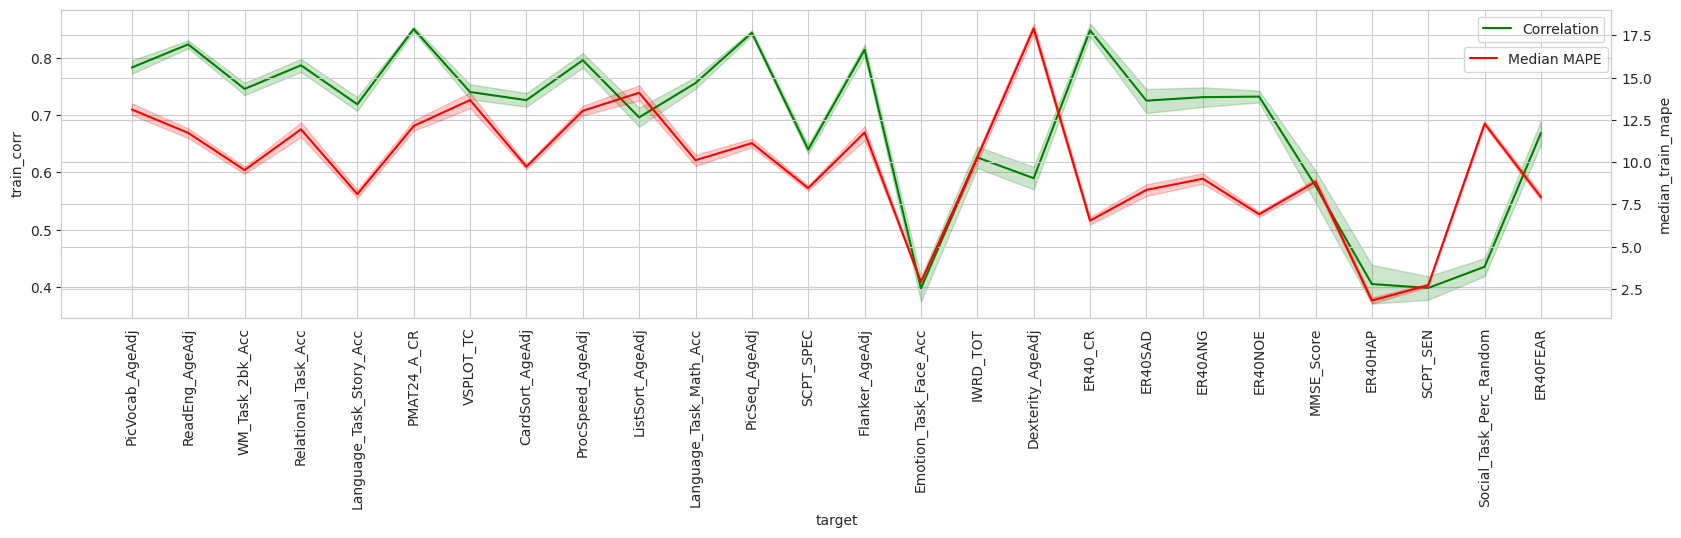

In [69]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,4))    
sns.lineplot(data=model_perf_df, x="target", y="train_corr", color="g", label="Correlation")
plt.xticks(rotation=90)
ax2 = plt.twinx()
sns.lineplot(data=model_perf_df, x="target", y="median_train_mape", ax=ax2,color="r", label="Median MAPE")
ax2.legend(bbox_to_anchor=(0.002, 0.80, 1., .102))

<Axes: xlabel='target', ylabel='median_test_mape'>

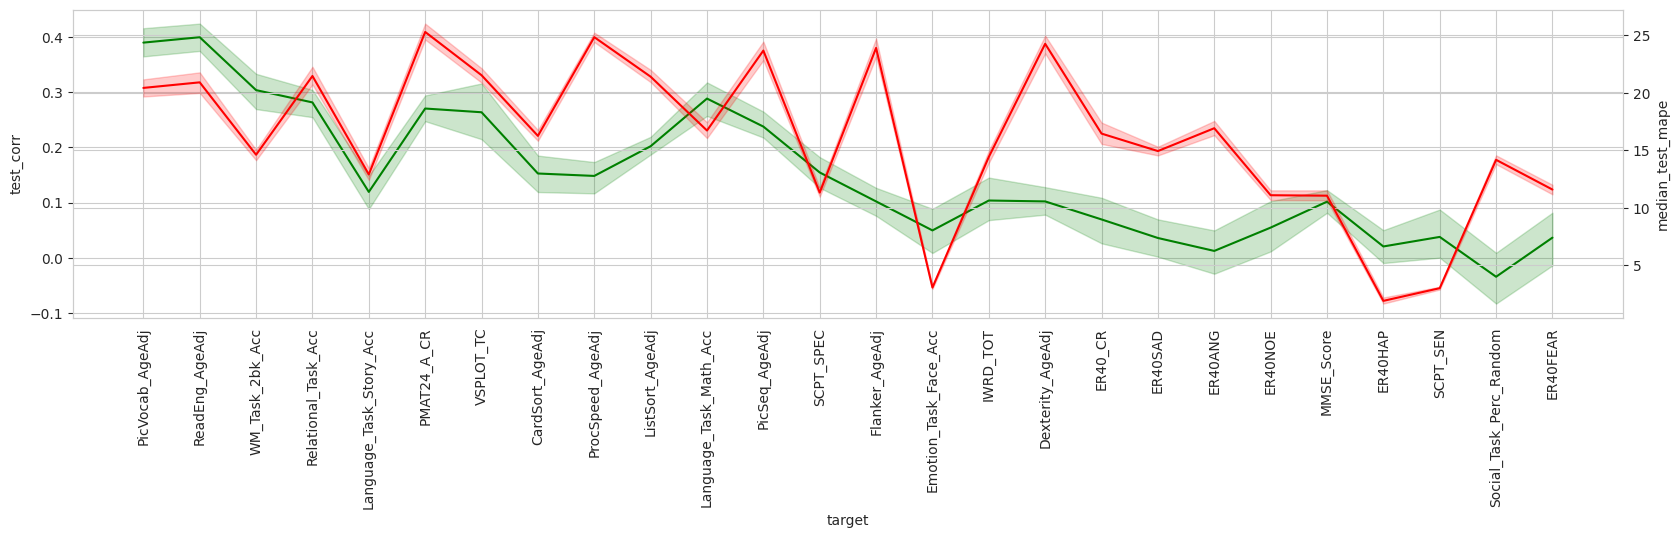

In [48]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,4))    
sns.lineplot(data=model_perf_df, x="target", y="test_corr", color="g")
plt.xticks(rotation=90)
ax2 = plt.twinx()
plt.xticks(rotation=90)
sns.lineplot(data=model_perf_df, x="target", y="median_test_mape", ax=ax2,color="r")



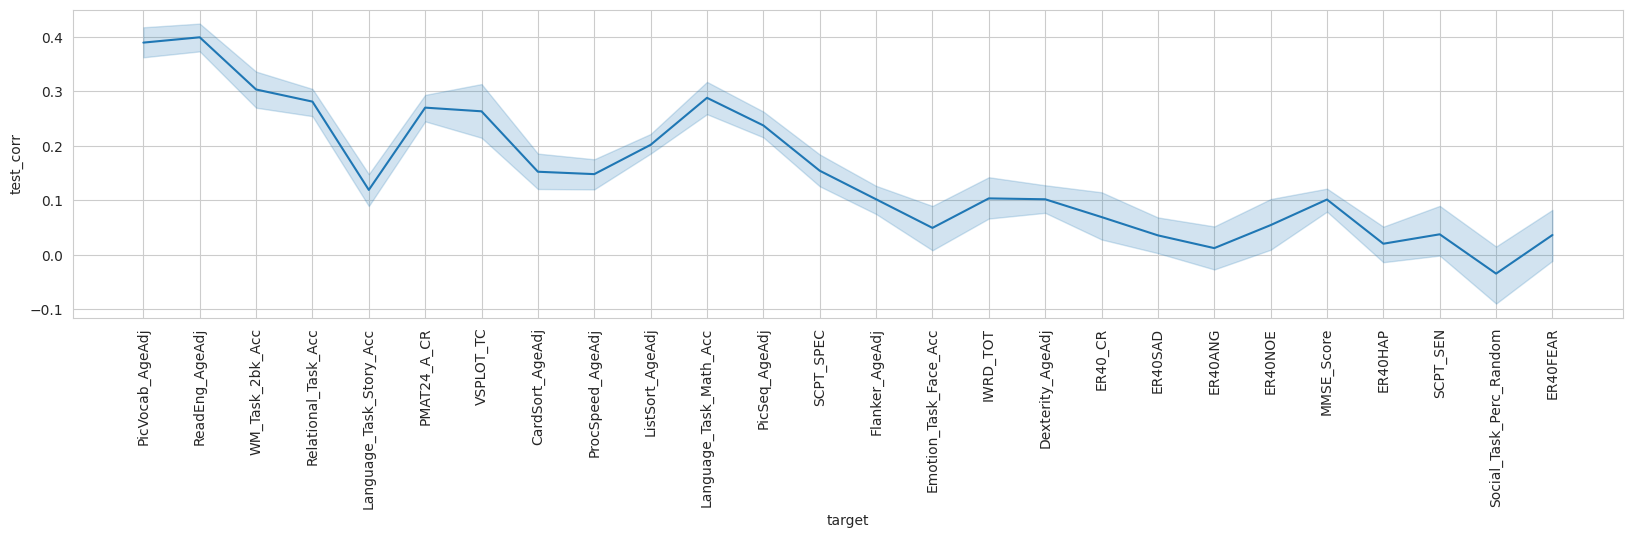

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,4))    
ax = sns.lineplot(data=model_perf_df, x="target", y="test_corr")
plt.xticks(rotation=90)
n_labels = range(len(np.unique(model_perf_df["target"].values)))

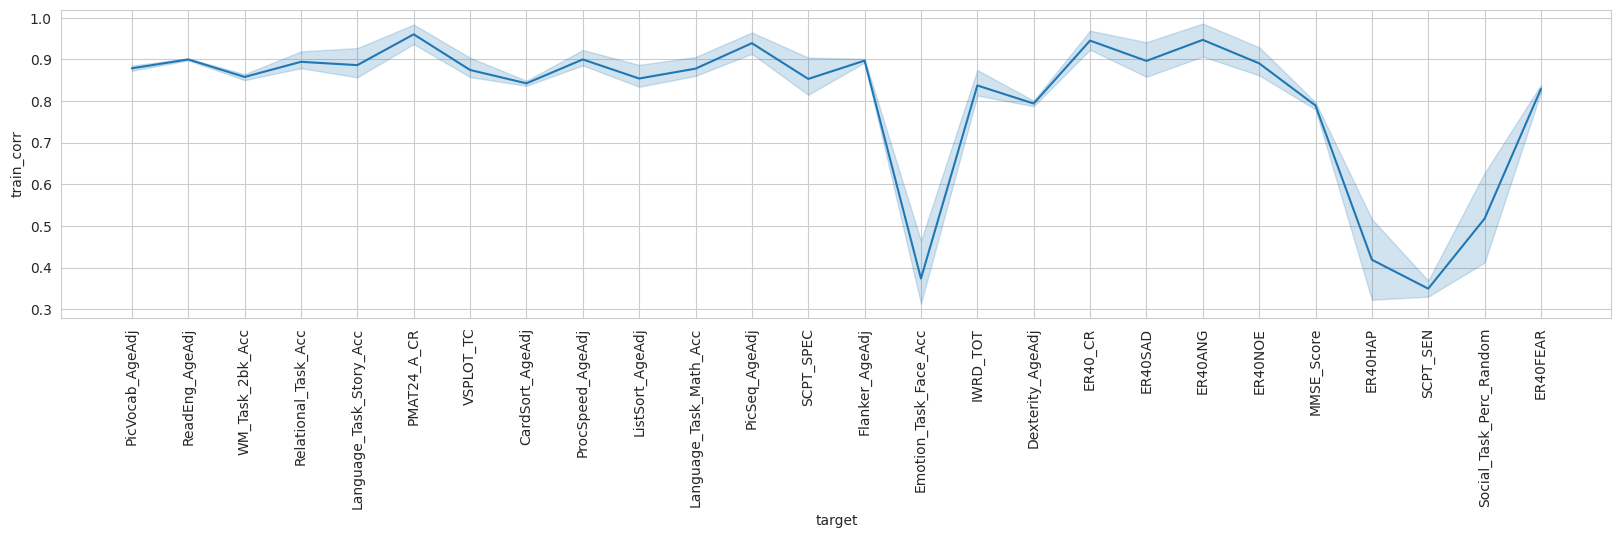

In [27]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,4))    
ax = sns.lineplot(data=model_perf_df, x="target", y="train_corr")
plt.xticks(rotation=90)
n_labels = range(len(np.unique(model_perf_df["target"].values)))

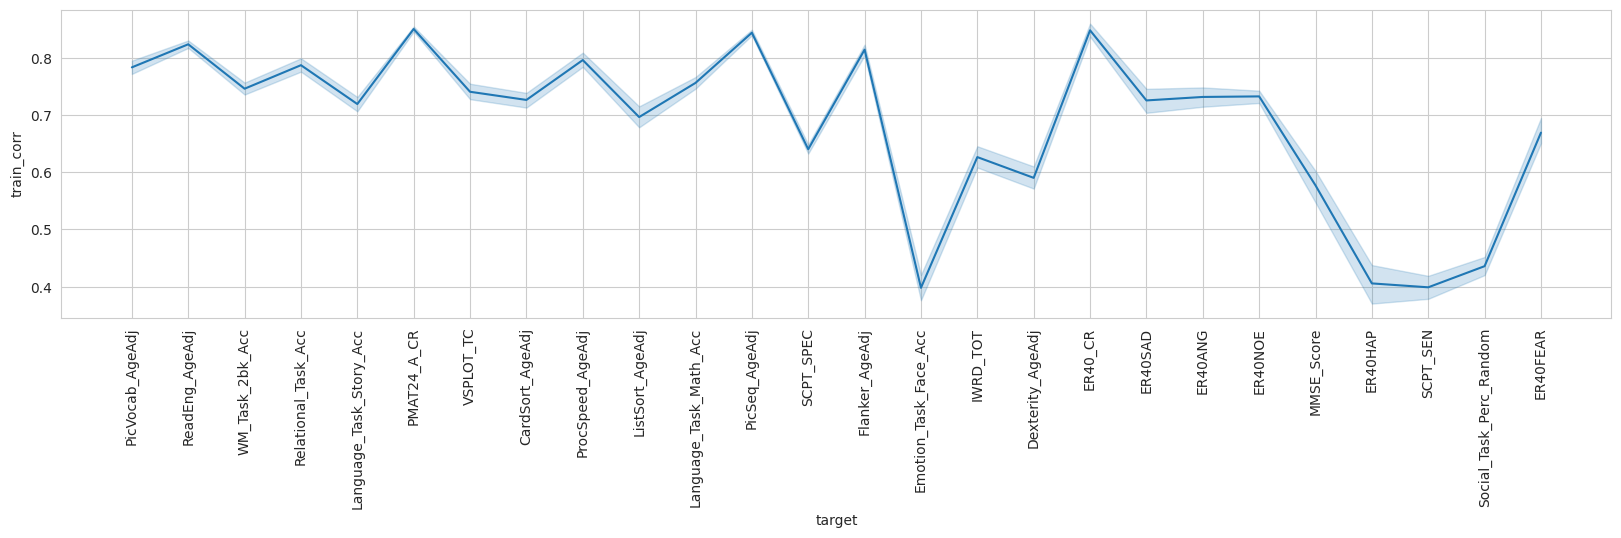

In [23]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,4))    
ax = sns.lineplot(data=model_perf_df, x="target", y="train_corr")
plt.xticks(rotation=90)
n_labels = range(len(np.unique(model_perf_df["target"].values)))



In [19]:
target = "PicVocab_AgeAdj"

In [20]:
y_train = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == train_ratio) & (predictions[run_type] == run_id)][target].values
y_test = predictions[(predictions["dataset"] == test_type) & (predictions["train_ratio"] == train_ratio) & (predictions[run_type] == run_id)][target].values

ridge_estimator = Ridge(alpha=1)
fitted_ridge = ridge_estimator.fit(X_train, y_train)
y_train_pred = fitted_ridge.predict(X_train)
y_test_pred = fitted_ridge.predict(X_test)

In [25]:
np.save(f"{exp_dir}/ridge_y_pred_train_{target}_{run_type}_{run_id}.npy", y_train_pred)
np.save(f"{exp_dir}/ridge_y_pred_test_{target}_{run_type}_{run_id}.npy", y_test_pred)

In [27]:
run_id

340

In [22]:
custom_corr(y_test, y_test_pred)

0.3756851855291548

In [23]:
custom_corr(y_train, y_train_pred)

0.7829681210685571

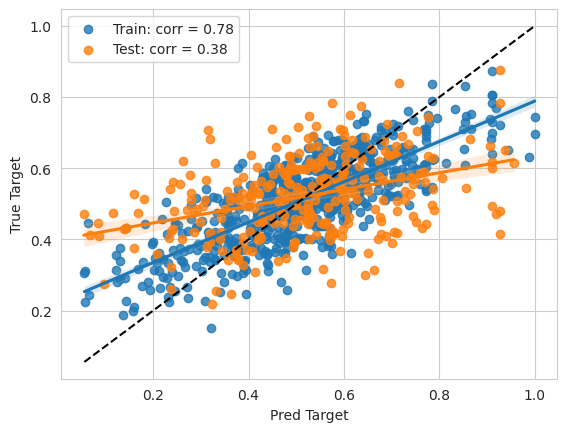

In [24]:
train_corr = custom_corr(y_train, y_train_pred)
test_corr = custom_corr(y_test, y_test_pred)

sns.regplot(x=y_train, y=y_train_pred, label=f"Train: corr = {train_corr:.2f}")
sns.regplot(x=y_test, y=y_test_pred, label=f"Test: corr = {test_corr:.2f}")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], linestyle='--', c='black')
plt.ylabel("True Target")
plt.xlabel("Pred Target")
plt.legend()
plt.show()

Text(0.5, 0, '')

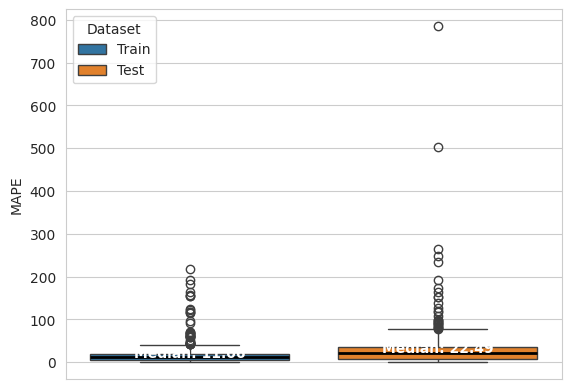

In [129]:
mape_df = pd.DataFrame({
    "sub_id": np.concat([sub_idx_train, sub_idx_test]),
    "dataset": ["Train"]*len(sub_idx_train) + ["Test"]*len(sub_idx_test),
    "MAPE": np.concat([100*np.abs(y_train-y_train_pred)/y_train, 100*np.abs(y_test-y_test_pred)/y_test])
})
median_mape_train = np.median(100*np.abs(y_train-y_train_pred)/y_train)
median_mape_test = np.median(100*np.abs(y_test-y_test_pred)/y_test)

sns.set_style("whitegrid")
sns.boxplot(data=mape_df, x='dataset', y='MAPE', hue='dataset',
            legend=True,
            medianprops={"color": "black", "linewidth": 2}
              )
plt.text(0, median_mape_train + 0.5, f'Median: {median_mape_train:.2f}', horizontalalignment='center', size='medium', color='white', weight='semibold')
plt.text(1, median_mape_test+ 0.5, f'Median: {median_mape_test:.2f}', horizontalalignment='center', size='medium', color='white', weight='semibold')
plt.xticks([], [])
# plt.ylim(-.05, 1.05)
plt.legend(title='Dataset', loc='upper left')
plt.xlabel('Value')
plt.xlabel('')


Text(0.5, 1.0, 'MAPE Test')

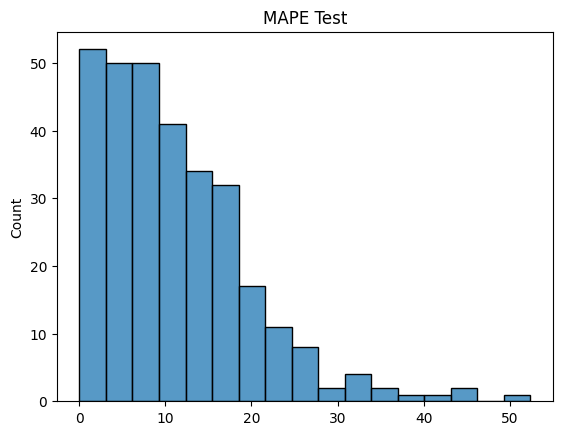

In [184]:
sns.histplot(x=100*np.abs(y_test-y_test_pred)/y_test)
plt.title("MAPE Test")

<Axes: xlabel='Mean of x and y', ylabel='x - y'>

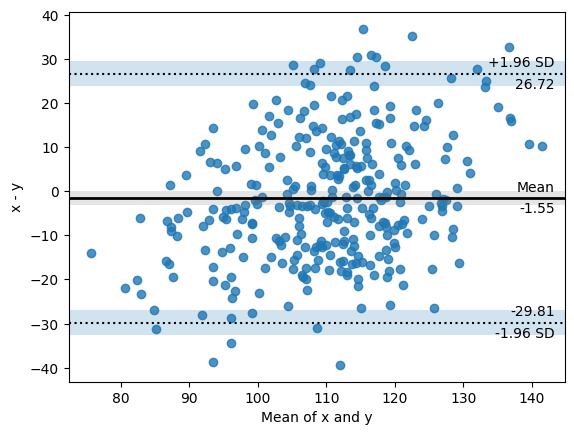

In [185]:
pg.plot_blandaltman(y_test, y_test_pred)